In [ ]:
! pip install faiss-gpu
! apt install libopenblas-dev
! pip install MulticoreTSNE

     |████████████████████████████████| 89.4MB 36kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopenblas-dev is already the newest version (0.2.20+ds-4).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=68502 sha256=b442f5cbf9fde6b8c95754278c30b2c40b140e0f9ad8119628de5af258f97045
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [ ]:
!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.7/dist-packages/

--2021-03-27 18:23:55--  https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.93.24, 104.17.92.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.93.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5d019c23c7424a015486440c/5d790a95778a870c42137059?response-content-disposition=attachment%3B%20filename%3D%22tsnecuda-2.1.0-cuda100.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27tsnecuda-2.1.0-cuda100.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20210327T182355Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEOb%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJGMEQCIHtSTXp4t%2FIxoqSg%2BCtdBaZUSn9z9YgkhyuReQi8y9kkAiBLdtRUvppLnEV2w4zqs6kh4FNY5sxwyMbQWyPxZnjnlyq0AwgvEAAaDDQ1NTg2NDA5ODM3OCIMh1c9%2BOCARZvkK8h1KpEDvUiR27CYj%2B8

In [ ]:
!echo $LD_LIBRARY_PATH 
!ln -s /content/lib/libfaiss.so $LD_LIBRARY_PATH/libfaiss.so

/usr/lib64-nvidia


In [ ]:
import pandas as pd
df = pd.read_csv('sample_data/mnist_train_small.csv', header=None, index_col=0)
df = df/255

In [ ]:
from sklearn.manifold import TSNE
import tsnecuda
from tsnecuda import TSNE as TSNE_CUDA
from MulticoreTSNE import MulticoreTSNE as mTSNE
from time import perf_counter

tsne_sklearn = TSNE(
    n_components=2, 
    perplexity=30.0, 
    early_exaggeration=12.0, 
    learning_rate=200.0, 
    n_iter=1000, 
    n_iter_without_progress=300, 
    min_grad_norm=1e-07, 
    metric='euclidean', 
    init='random', 
    verbose=0, 
    random_state=42, 
    # angle=0.5
)

tsne_mcore = mTSNE(
    n_components=2, 
    perplexity=30.0, 
    early_exaggeration=12.0, 
    learning_rate=200.0, 
    n_iter=1000, 
    n_iter_without_progress=300, 
    min_grad_norm=1e-07, 
    metric='euclidean', 
    init='random', 
    verbose=0, 
    random_state=42, 
    # angle=0.5,
    n_jobs = -1
)
tsne_cuda = TSNE_CUDA(
    n_components=2, 
    perplexity=30.0, 
    early_exaggeration=12.0, 
    learning_rate=200.0, 
    n_iter=1000, 
    n_iter_without_progress=300, 
    min_grad_norm=1e-07, 
    metric='euclidean', 
    init='random', 
    verbose=0,
    random_seed=42, # different parameter name
    # theta=0.5 # different parameter name
)

tsne (sklearn) done in 790.023324449 seconds


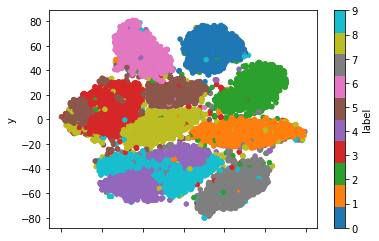

In [ ]:
t0 = perf_counter()
embeddings_sklearn = tsne_sklearn.fit_transform(df)
print(f'tsne (sklearn) done in {perf_counter() - t0} seconds')
pd.DataFrame(
    embeddings_sklearn
).rename(
    columns={0:'x',1:'y'}
).assign(
    label=df.index
).plot.scatter(x='x',y='y',c='label',cmap='tab10')

tsne-mcore done in 223.71467058500002 seconds


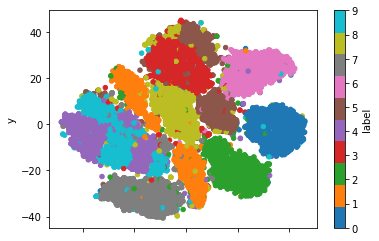

In [ ]:
t0 = perf_counter()
embeddings_mcore = tsne_mcore.fit_transform(df)
print(f'tsne-mcore done in {perf_counter() - t0} seconds')
pd.DataFrame(
    embeddings_mcore
).rename(
    columns={0:'x',1:'y'}
).assign(
    label=df.index
).plot.scatter(x='x',y='y',c='label',cmap='tab10')

tsne-cuda done in 5.652213001999996 seconds


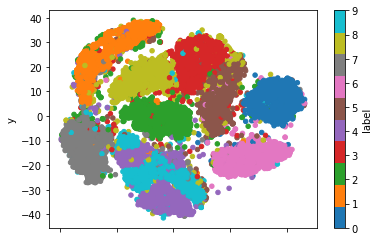

In [ ]:
t0 = perf_counter()
embeddings_gpu = tsne_cuda.fit_transform(df)
print(f'tsne-cuda done in {perf_counter() - t0} seconds')
pd.DataFrame(
    embeddings_gpu
).rename(
    columns={0:'x',1:'y'}
).assign(
    label=df.index
).plot.scatter(x='x',y='y',c='label',cmap='tab10')